# Introduction

Before running this notebook for the first time, follow these steps to prepare your data:

1.   Download the 6 mosquito folders from *Kaggle*
2.   Make sure each species folder has the same structure: *species/date/audio.wav*
3.   Run `Extract_Split.py` to end up with 3 main folders **Train**, **CV** and **Test**, with data for all species in each of them
4.   Zip the 3 folders and upload them into Google Drive
5.   Run the notebook `Mosquito_Read_Store_Amplitudes.ipynb`
6.   You should have 10 pickle-files on Google Drive:

> *   6 for training amplitudes, each named after a mosquito species (data would have been too large to save it as a single pickle)
> *   2 for cv set (amplitudes and labels)
> *   2 for test set (amplitudes and labels)

7. Download the 8 files with the amplitudes on your PC, zip them under 3 folders corresponding to each set and upload them again on Drive. Delete the pickled amplitudes from Drive.


In [ ]:
# Import built-in Python libraries
from matplotlib import pyplot as plt
from scipy import signal
from librosa import display

%tensorflow_version 2.x
import tensorflow as tf

import numpy as np
import scipy.io.wavfile
import seaborn as sns
import librosa
import glob
import os
import pickle
import time
import datetime
import importlib

# Define path to scripts and py-files
scripts_dir = '/content/drive/My Drive/KInsekten/Scripts/'

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Choose between CPU, GPU and TPU:


In [ ]:
strategy = 'CPU' #@param ["CPU", "GPU", "TPU"]

if strategy is 'CPU':
  strategy = tf.distribute.OneDeviceStrategy(device="/cpu:0")
  print('/device:CPU:0')
elif strategy is 'GPU':
  if tf.config.list_physical_devices('GPU'):
    policy = tf.keras.mixed_precision.experimental.Policy('mixed_float16') 
    tf.keras.mixed_precision.experimental.set_policy(policy) 
    tf.test.gpu_device_name()
    strategy = tf.distribute.MirroredStrategy()
  else:
    print('No GPU detected')
elif strategy is 'TPU':
  try:
    resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
    tf.config.experimental_connect_to_cluster(resolver)
    tf.tpu.experimental.initialize_tpu_system(resolver)
    strategy = tf.distribute.experimental.TPUStrategy(resolver)
  except ValueError:
    print('No TPU detected')

/device:CPU:0


External files

In [ ]:
# Import custom libraries
os.chdir(scripts_dir)
import Mosquito_Functions
import Mosquito_Models

In [ ]:
# In case you modify the libraries during the session, you can reload them
os.chdir(scripts_dir)
importlib.reload(Mosquito_Functions)
importlib.reload(Mosquito_Models)

/content/drive/My Drive/KInsekten


<module 'Mosquito_Models' from '/content/drive/My Drive/KInsekten/Mosquito_Models.py'>

In [ ]:
# Import constants and custom functions
os.chdir(scripts_dir)
from Mosquito_Functions import data_path, drive_path, species, sampling_rate 
from Mosquito_Functions import load_amplitudes, mean_plot, shift_data, get_uniform_random_samples
from Mosquito_Functions import convert_to_psd, plot_accuracy, plot_confusion

from Mosquito_Models import Mosquito_CNN_PSD

Set whether to use the test set or not

In [ ]:
use_test = False #@param {type:"boolean"}

# Loading amplitudes

In [ ]:
os.chdir(scripts_dir)
#!python Mosquito_Prepare_Environment.py -h # prints usage

# Create folders and copy data from Drive
if use_test:
  !python Mosquito_Prepare_Environment.py True
else:
  !python Mosquito_Prepare_Environment.py False

Running Mosquito_Load_Amplitudes.py
Loading Train and CV.
###################################

Train_amplitudes.zip copied
CV_amplitudes.zip copied
CV_labels.pickle copied
43 seconds

Train_amplitudes unzipped
CV_amplitudes unzipped
71 seconds



In [ ]:
# Build matrices and labels from copied raw amplitudes
start_time = time.time()
X_train, X_cv, X_test, y_train, y_cv, y_test = load_amplitudes(use_test = use_test)
print("%s seconds" % int(time.time() - start_time))

Train_Ae_aegypti loaded: 51331
Train_Ae_albopictus loaded: 12138
Train_An_arabiensis loaded: 11577
Train_An_gambiae loaded: 29682
Train_Cu_pipiens loaded: 18249
Train_Cu_quinquefasciatus loaded: 44759
167736 training audios

Training list flattened

CV amplitudes loaded
CV labels loaded
55914 cv audios

5 seconds


Distribution of audios per species and per set:

Species | Training set | CV set | Test set
--- | --- | --- | ---
Ae_aegypti | 51331 | 17111 | 17111 
Ae_albopictus | 12138 | 4046 | 4047
An_arabiensis | 11577 | 3860 | 3860
An_gambiae | 29682 | 9894 | 9895
Cu_pipiens | 18249 | 6083 | 6083
Cu_quinquefasciatus | 44759 | 14920 | 14920
**Total** | **167736** | **55914** | **55916**


# Data preprocessing

## PSD

Convert matrices of raw amplitudes to PSD values

In [ ]:
# Parameters for Welch-PSD
window_psd   = 'hanning' # window function ('hanning' is a squared cosine filter)
nperseg_psd  = 256       # length of each segment 
noverlap_psd = 128+64    # = segment length - step size (usually ~50% of nperseg)

In [ ]:
# Calculate the PSD separately for the first signal, in order to store
# the sample frequencies once. They are the same for the PSD of every signal
#freqs_psd, _ = signal.welch(X_train[0], fs = sampling_rate, window = window_psd, 
#                            nperseg = nperseg_psd, noverlap = noverlap_psd)

# Convert Train, CV and Test to PSD
start_time = time.time()

convert_to_psd(X_train, sampling_rate, window_psd, nperseg_psd, noverlap_psd)

convert_to_psd(X_cv, sampling_rate, window_psd, nperseg_psd, noverlap_psd)

if use_test:
  convert_to_psd(X_test, sampling_rate, window_psd, nperseg_psd, noverlap_psd)

print("\n" + "%s seconds" % int(time.time() - start_time))

# Store the new signal length
len_signal = len(X_train[0])

/content/drive/My Drive/KInsekten/Scripts/Mosquito_Functions.py:148: RuntimeWarning: divide by zero encountered in log10
  nperseg = nperseg, noverlap = noverlap))


0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
Converted to PSD. New shape: (167736, 129)
0
10000
20000
30000
40000
50000
Converted to PSD. New shape: (55914, 129)

135 seconds


## Format conversion

The labels in the y-vectors represent 6 categorical classes. In order to avoid one-hot-encoding, a loss function of type *Sparse categorical crossentropy* is used. The data matrices should be extended with one extra dimension, to match the requirements of the Keras model input. 

In [ ]:
# Add one extra dimension to the matrices (to fit training format) 
# Convert signals and labels to Numpy arrays

start_time = time.time()

X_train = np.expand_dims(X_train, axis = -1).astype(np.float32)
y_train = np.asarray(y_train, dtype = np.uint8)
print('Train expanded and converted\n')

X_cv = np.expand_dims(X_cv, axis = -1).astype(np.float32)
y_cv = np.asarray(y_cv, dtype = np.uint8)
print('CV expanded and converted\n')

if use_test:
  X_test = np.expand_dims(X_test, axis = -1).astype(np.float32)
  y_test = np.asarray(y_test, dtype = np.uint8)
  print('Test expanded and converted\n')

print("%s seconds\n" % int(time.time() - start_time))

Train expanded and converted

CV expanded and converted

0 seconds



In [ ]:
# Optional: Choose uniform random samples from the training and cv sets
ind_train = [0, 51331, 63469, 75046, 104728, 122977, 167736] 
X_train_sample, y_train_sample = get_uniform_random_samples(X_train, y_train, 
                                                            sample_size = 1000, indices = ind_train)

ind_cv = [0, 17111, 21157, 25017, 34911, 40994, 55914]
X_cv_sample, y_cv_sample = get_uniform_random_samples(X_cv, y_cv, 
                                                      sample_size = 300, indices = ind_cv)

# Train model

## Define parameters

In [ ]:
# Define name of the model 
models = ['Mosquito_CNN_Test', 'Mosquito_CNN_PSD']
model_index = 1
model_name = models[model_index]

# Define model class to construct
model_class = Mosquito_CNN_PSD

# Define useful paths derived from the model's name:
os.chdir(drive_path)
### Tensor Board logs
logs_dir = 'Models/' + model_name + '/logs/'
### File for saving model's weights during training
weights_file = 'Models/' + model_name + '/' + model_name + '.h5'
### Folder to store training histories
histories_dir = 'Models/' + model_name + '/histories/'

In [ ]:
# Define initial training parameters
epochs = 30
batch_size = 64
lr = 5e-3 # learning rate
reg_param = 5e-4 # L2 regularizing parameter
lr_schedule_index = 0 # Reduce_Plateau

Conversion to `tf.data.Dataset`

**Prefetching** (load next batch already while training on the current one), **Batch_Split** (data is split into batches already before startinh the training) and **Caching** (only load dataset once before the first epoch).

**Note:** The training set needs to be shuffled before being split into batches. otherwise whole batches will contain only examples from one species. This leads to deadly overfitting x_x

In [ ]:
# Build training set from training matrix and labels
train_set = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_set = train_set.shuffle(buffer_size = len(X_train), reshuffle_each_iteration = True) # Important! Shuffle before batch()
train_set = train_set.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE).cache()

# Build cv set from cv matrix and labels
cv_set = tf.data.Dataset.from_tensor_slices((X_cv, y_cv))
cv_set = cv_set.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE).cache() 

## Hyperparameter optimization

Three hyperparameters are going to be tuned: 
1.   *Learning rate schedule* (what function should determine how the lr changes as training progresses) along with its value domain (boundaries between which the lr is allowed to oscillate)
2.   *Learning rate* (as a maximum value in the lr schedule)
3.   *Regularization parameter* (only applied on the weights of the final Dense layer, not on the convolutional layers)



###Learning rate schedule 1

$lr \in [10^{-3}, 10^{-4}], reg = 0$ 

In [ ]:
schedules = ['Reduce_Plateau', 'Triangle_Decay', 'Exponential_Decay']
os.chdir(histories_dir + 'lr_schedules_1')

In [ ]:
# Grid search for all lr schedules
for i in range(len(schedules)): 

  print("\n*** TRAINING WITH SCHEDULE " + schedules[i] + " ***")

  with strategy.scope(): 
    model = model_class(lr = lr, lr_schedule_index = i, reg_param = reg_param, 
                        logs_dir = logs_dir, save_model_path = weights_file, model_name = model_name)
  model.callbacks = model.callbacks[2] # Don't save weights and deactivate Early Stopping and Tensor Board

  history = model.fit(train_set,
                      epochs = epochs,
                      validation_data = cv_set,
                      callbacks = model.callbacks)

  # Save the history on Drive
  with open('History_' + model_name + '_' + schedules[i] + '.pickle', 'wb') as f:
    pickle.dump(history.history, f)


*** TRAINING WITH SCHEDULE Reduce_Plateau ***
Epoch 1/35
2621/2621 [==============================] - 89s 34ms/step - loss: 0.6073 - accuracy: 0.7814 - val_loss: 0.5626 - val_accuracy: 0.8002 - lr: 0.0010
Epoch 2/35
2621/2621 [==============================] - 86s 33ms/step - loss: 0.4718 - accuracy: 0.8282 - val_loss: 0.4367 - val_accuracy: 0.8432 - lr: 0.0010
Epoch 3/35
2621/2621 [==============================] - 87s 33ms/step - loss: 0.4354 - accuracy: 0.8417 - val_loss: 0.4127 - val_accuracy: 0.8521 - lr: 0.0010
Epoch 4/35
2621/2621 [==============================] - 87s 33ms/step - loss: 0.4108 - accuracy: 0.8519 - val_loss: 0.4256 - val_accuracy: 0.8492 - lr: 0.0010
Epoch 5/35
2621/2621 [==============================] - 86s 33ms/step - loss: 0.3948 - accuracy: 0.8574 - val_loss: 0.4552 - val_accuracy: 0.8357 - lr: 0.0010
Epoch 6/35
2621/2621 [==============================] - 86s 33ms/step - loss: 0.3806 - accuracy: 0.8618 - val_loss: 0.3929 - val_accuracy: 0.8579 - lr: 0.0010

In [ ]:
# Load histories from Drive
hist_paths = glob.glob('*.pickle')
list.sort(hist_paths)
histories = []
for hist_path in hist_paths:
  with open(hist_path, 'rb') as f:
    histories.append(pickle.load(f))

Plot learning rates for each schedule

*Reduce_Plateau* shrinks the lr by a factor of 2; Triangles get twice as small

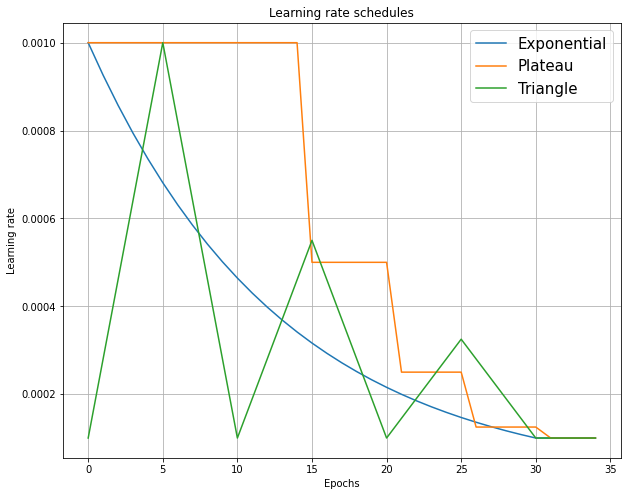

In [ ]:
plt.figure(figsize = (10, 8))
for hist in histories:
  plt.plot(hist['lr'])
plt.title('Learning rate schedules')
plt.xlabel('Epochs')
plt.ylabel('Learning rate')
plt.legend(['Exponential', 'Plateau', 'Triangle'], fontsize = 15)
plt.grid()
plt.show()

Plot validation accuracies for each schedule

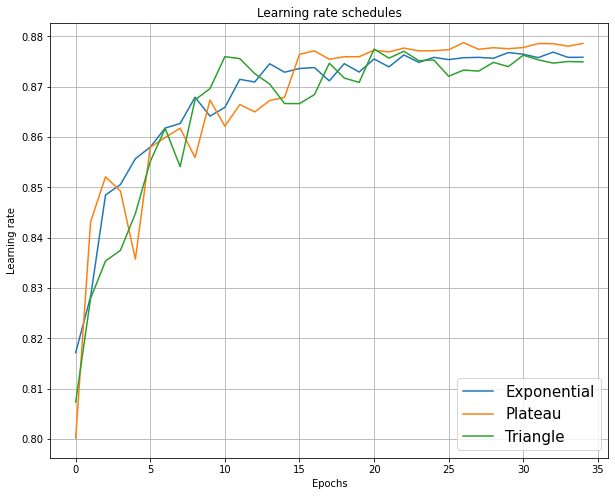

In [ ]:
plt.figure(figsize = (10, 8))
for hist in histories:
  plt.plot(hist['val_accuracy'])
plt.title('Validation accuracy per learning rate schedule')
plt.xlabel('Epochs')
plt.ylabel('Validation accuracy')
plt.legend(['Exponential', 'Plateau', 'Triangle'], loc = 'lower right', fontsize = 15)
plt.grid()
plt.show()

Plot validation losses for each schedule

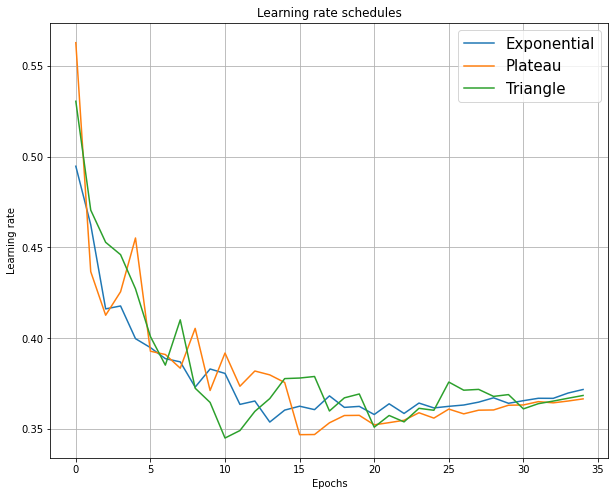

In [ ]:
plt.figure(figsize = (10, 8))
for hist in histories:
  plt.plot(hist['val_loss'])
plt.title('Validation loss per learning rate schedule')
plt.xlabel('Epochs')
plt.ylabel('Validation loss')
plt.legend(['Exponential', 'Plateau', 'Triangle'], fontsize = 15)
plt.grid()
plt.show()

Plot all accuracy curves

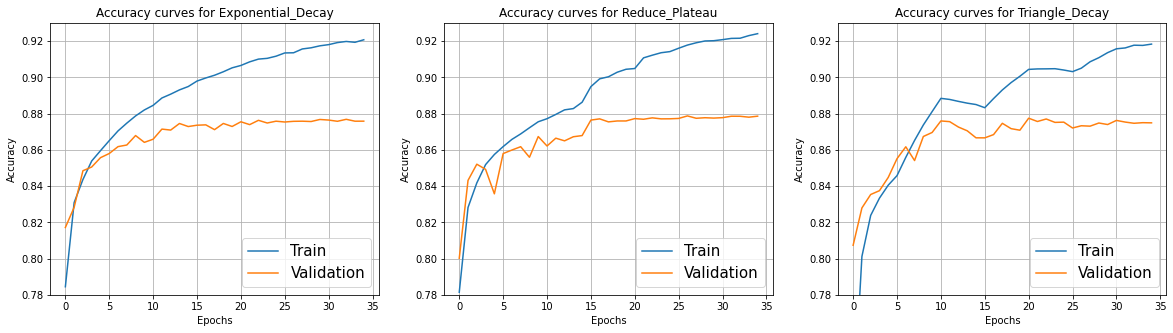

In [ ]:
list.sort(schedules)
plot_base_index = 130
plt.figure(figsize = (20, 5))
for i in range(len(histories)):
  plt.subplot(plot_base_index + i + 1)
  plt.plot(histories[i]['accuracy'])
  plt.plot(histories[i]['val_accuracy'])
  plt.title('Accuracy curves for ' + schedules[i])
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.ylim(top = 0.93, bottom = 0.78)
  plt.legend(['Train', 'Validation'], loc = 'lower right', fontsize = 15)
  plt.grid()
plt.show()

It seems that *Reduce_Plateau* gives the best results, although with some amount of overfitting. Let's increse the value intervall of our lr, to see if we get any improvements.

### Learning rate schedule 2

$lr \in [10^{-3}, 10^{-5}], reg = 0$ 

In [ ]:
schedules = ['Reduce_Plateau', 'Triangle_Decay', 'Exponential_Decay']
os.chdir(histories_dir + 'lr_schedules_2')

In [ ]:
# Grid search for all lr schedules
for i in range(len(schedules)): 

  print("\n*** TRAINING WITH SCHEDULE " + schedules[i] + " ***")

  with strategy.scope(): 
    model = model_class(lr = lr, lr_schedule_index = i, reg_param = reg_param, 
                        logs_dir = logs_dir, save_model_path = weights_file, model_name = model_name)
  model.callbacks = model.callbacks[2] # Don't save weights and deactivate Early Stopping and Tensor Board

  history = model.fit(train_set,
                      epochs = epochs,
                      validation_data = cv_set,
                      callbacks = model.callbacks)

  # Save the history on Drive
  with open('History_' + model_name + '_' + schedules[i] + '.pickle', 'wb') as f:
    pickle.dump(history.history, f)


*** TRAINING WITH SCHEDULE Reduce_Plateau ***
Epoch 1/35
2621/2621 [==============================] - 89s 34ms/step - loss: 0.5950 - accuracy: 0.7861 - val_loss: 0.5130 - val_accuracy: 0.8110 - lr: 0.0010
Epoch 2/35
2621/2621 [==============================] - 88s 34ms/step - loss: 0.4674 - accuracy: 0.8306 - val_loss: 0.4311 - val_accuracy: 0.8449 - lr: 0.0010
Epoch 3/35
2621/2621 [==============================] - 90s 34ms/step - loss: 0.4310 - accuracy: 0.8430 - val_loss: 0.4284 - val_accuracy: 0.8447 - lr: 0.0010
Epoch 4/35
2621/2621 [==============================] - 88s 34ms/step - loss: 0.4090 - accuracy: 0.8519 - val_loss: 0.3964 - val_accuracy: 0.8574 - lr: 0.0010
Epoch 5/35
2621/2621 [==============================] - 88s 33ms/step - loss: 0.3903 - accuracy: 0.8575 - val_loss: 0.4441 - val_accuracy: 0.8426 - lr: 0.0010
Epoch 6/35
2621/2621 [==============================] - 89s 34ms/step - loss: 0.3778 - accuracy: 0.8626 - val_loss: 0.3738 - val_accuracy: 0.8652 - lr: 0.0010

In [ ]:
# Load histories from Drive
hist_paths = glob.glob('*.pickle')
list.sort(hist_paths)
histories = []
for hist_path in hist_paths:
  with open(hist_path, 'rb') as f:
    histories.append(pickle.load(f))

Plot learning rates for each schedule 

Note that *Reduce_Plateau* shrinks the lr by a factor of 10 now

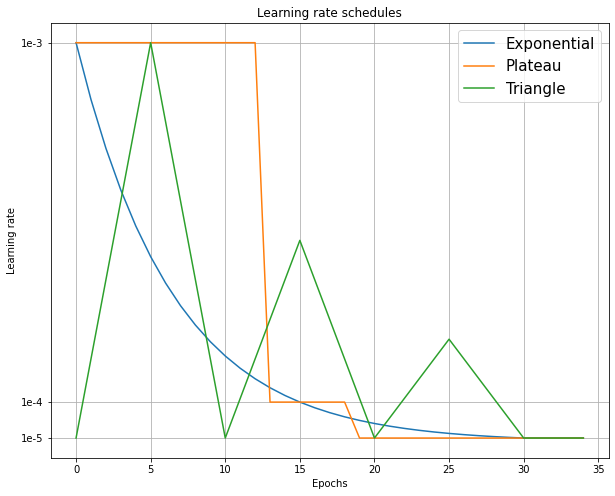

In [ ]:
plt.figure(figsize = (10, 8))
for hist in histories:
  plt.plot(hist['lr'])
plt.yticks(ticks = [1e-3, 1e-4, 1e-5], labels = ['1e-3', '1e-4', '1e-5'])
plt.title('Learning rate schedules')
plt.xlabel('Epochs')
plt.ylabel('Learning rate')
plt.legend(['Exponential', 'Plateau', 'Triangle'], fontsize = 15)
plt.grid()
plt.show()

Plot validation accuracies for each schedule

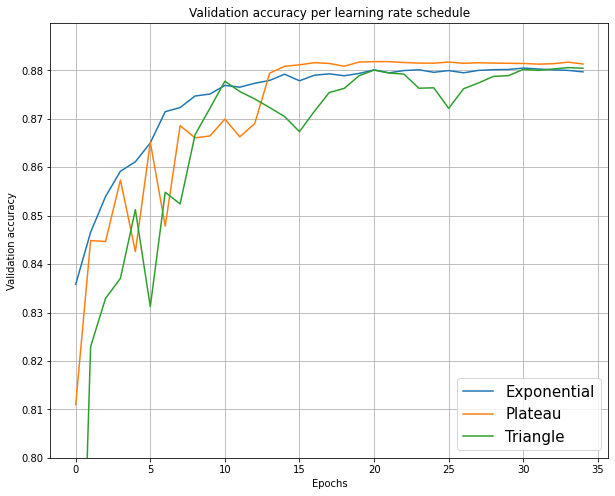

In [ ]:
plt.figure(figsize = (10, 8))
for hist in histories:
  plt.plot(hist['val_accuracy'])
plt.ylim(bottom = 0.8)
plt.title('Validation accuracy per learning rate schedule')
plt.xlabel('Epochs')
plt.ylabel('Validation accuracy')
plt.legend(['Exponential', 'Plateau', 'Triangle'], loc = 'lower right', fontsize = 15)
plt.grid()
plt.show()

Plot validation losses for each schedule

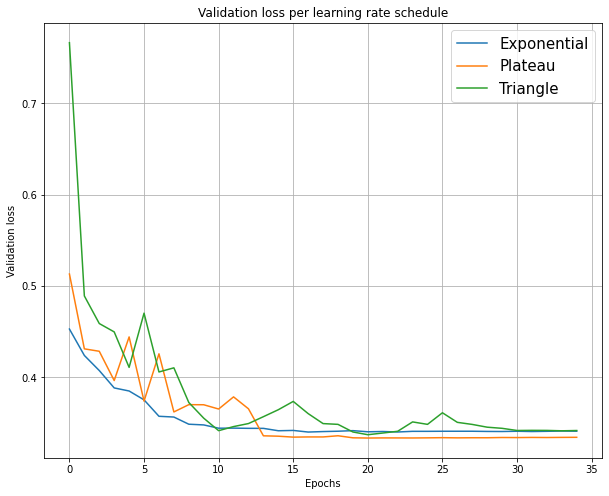

In [ ]:
plt.figure(figsize = (10, 8))
for hist in histories:
  plt.plot(hist['val_loss'])
plt.title('Validation loss per learning rate schedule')
plt.xlabel('Epochs')
plt.ylabel('Validation loss')
plt.legend(['Exponential', 'Plateau', 'Triangle'], fontsize = 15)
plt.grid()
plt.show()

Plot all accuracy curves

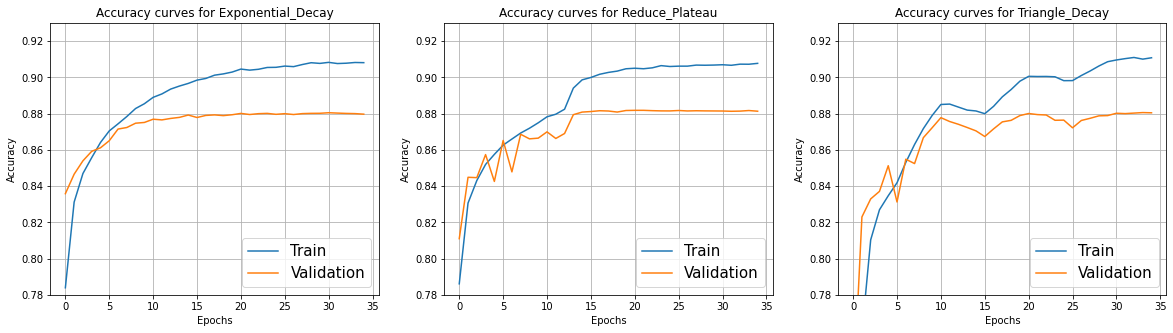

In [ ]:
list.sort(schedules)
plot_base_index = 130
plt.figure(figsize = (20, 5))
for i in range(len(histories)):
  plt.subplot(plot_base_index + i + 1)
  plt.plot(histories[i]['accuracy'])
  plt.plot(histories[i]['val_accuracy'])
  plt.title('Accuracy curves for ' + schedules[i])
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.ylim(top = 0.93, bottom = 0.78)
  plt.legend(['Train', 'Validation'], loc = 'lower right', fontsize = 15)
  plt.grid()
plt.show()

*Reduce_Plateau* still outperforms the other two strategies and by increasing its range of values and its multiplication rate, we also managed to smooth out some of the overfitting. The next computations will all be using this schedule during training.

###Learning rate and regularization parameter 1

We choose an initial *parameter grid* for our maximal lr and reg_param. After looking at the scores achieved by all combinations, we might decide to 'zoom in' around the best parameter pair and try out further combinations in the vicinity of that pair.

In [ ]:
lrates   = [1e-4, 1e-3, 1e-2] 
lr_names = ['1e-4', '1e-3', '1e-2']
reg_params = [0, 1e-4, 1e-3, 1e-2, 1e-1, 1] 
reg_names  = ['0', '1e-4', '1e-3', '1e-2', '1e-1', '1']
os.chdir(histories_dir + 'lr_reg_1')

In [ ]:
# Grid search for all defined combinations of lr and reg_param
for i in range(len(lrates)): 
  for j in range(len(reg_params)):

    print("\n*** TRAINING WITH LR = " + lr_names[i] + " AND REG = " + reg_names[j] + " ***")

    with strategy.scope(): 
      model = model_class(lr = lrates[i], lr_schedule_index = 0, reg_param = reg_params[j], 
                          logs_dir = logs_dir, save_model_path = weights_file, model_name = model_name)
    model.callbacks = model.callbacks[1:3] # Don't save weights and deactivate Tensor Board

    history = model.fit(train_set,
                        epochs = epochs,
                        validation_data = cv_set,
                        callbacks = model.callbacks)
    
    # Save the history on Drive
    with open('History_' + model_name + '_lr_' + lr_names[i] + '_reg_' + reg_names[j] + '.pickle', 'wb') as f:
      pickle.dump(history.history, f)


*** TRAINING WITH LR = 1e4 AND REG = 0 ***
Epoch 1/30
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost

In [ ]:
# Load histories from Drive
hist_paths = glob.glob('*.pickle')
list.sort(hist_paths)

In [ ]:
hist_paths = np.reshape(hist_paths, (len(lrates), len(reg_params))) # rows = lrates, cols = reg_params
hist_paths = np.roll(hist_paths, -1, axis = 1) # move reg_0 to the end to get a descending horizontal order
hist_paths = np.fliplr(hist_paths) # reverse horizontal lists -> ascending order
print(hist_paths)

[['History_Mosquito_CNN_PSD_lr_1e-2_reg_0.pickle'
  'History_Mosquito_CNN_PSD_lr_1e-2_reg_1e-4.pickle'
  'History_Mosquito_CNN_PSD_lr_1e-2_reg_1e-3.pickle'
  'History_Mosquito_CNN_PSD_lr_1e-2_reg_1e-2.pickle'
  'History_Mosquito_CNN_PSD_lr_1e-2_reg_1e-1.pickle'
  'History_Mosquito_CNN_PSD_lr_1e-2_reg_1.pickle']
 ['History_Mosquito_CNN_PSD_lr_1e-3_reg_0.pickle'
  'History_Mosquito_CNN_PSD_lr_1e-3_reg_1e-4.pickle'
  'History_Mosquito_CNN_PSD_lr_1e-3_reg_1e-3.pickle'
  'History_Mosquito_CNN_PSD_lr_1e-3_reg_1e-2.pickle'
  'History_Mosquito_CNN_PSD_lr_1e-3_reg_1e-1.pickle'
  'History_Mosquito_CNN_PSD_lr_1e-3_reg_1.pickle']
 ['History_Mosquito_CNN_PSD_lr_1e-4_reg_0.pickle'
  'History_Mosquito_CNN_PSD_lr_1e-4_reg_1e-4.pickle'
  'History_Mosquito_CNN_PSD_lr_1e-4_reg_1e-3.pickle'
  'History_Mosquito_CNN_PSD_lr_1e-4_reg_1e-2.pickle'
  'History_Mosquito_CNN_PSD_lr_1e-4_reg_1e-1.pickle'
  'History_Mosquito_CNN_PSD_lr_1e-4_reg_1.pickle']]


In [ ]:
# Arrays to store min losses and max accuracies
min_losses = np.zeros(np.shape(hist_paths))
max_accuracies = np.zeros(np.shape(hist_paths))

In [ ]:
# Read history files and compute min_loss and max_acc
for i in range(np.shape(hist_paths)[0]):
  for j in range(np.shape(hist_paths)[1]):
    with open(hist_paths[i, j], 'rb') as f:
      complete_hist = pickle.load(f)
    min_losses[i, j] = min(complete_hist['val_loss'])
    max_accuracies[i, j] = max(complete_hist['val_accuracy'])

In [ ]:
print(min_losses)

[[0.34833053 0.34777543 0.35794717 0.37386802 0.3901335  0.44051489]
 [0.33583125 0.34386367 0.3577055  0.36273229 0.38638458 0.41437328]
 [0.35862005 0.35318869 0.36133134 0.37813833 0.40481177 0.43576068]]


In [ ]:
print(max_accuracies)

[[0.87747252 0.87893909 0.87809849 0.87579137 0.87080157 0.85688734]
 [0.88178271 0.88106734 0.87951142 0.87884969 0.87212503 0.8673141 ]
 [0.8702293  0.87339485 0.87350214 0.87139177 0.86595488 0.86157316]]


In [ ]:
lr_names = lr_names[::-1] # reverse lr labels, to have the highest value up on the map axis
print(lr_names)

['1e-2', '1e-3', '1e-4']


Plot minimal validation losses as heat map

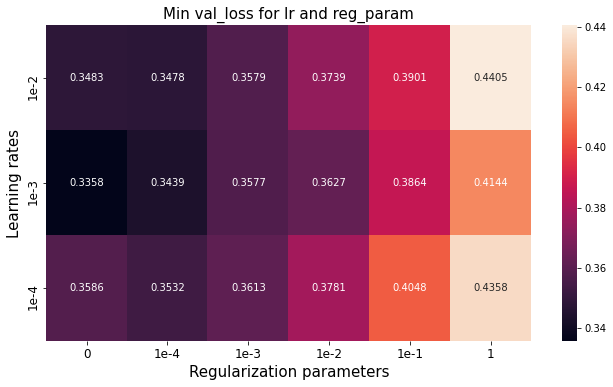

In [ ]:
plt.figure(figsize=(9, 5))
sns.heatmap(min_losses, annot = True, fmt = '.4g', cmap = 'rocket', # lowest value gets the darkest color
            xticklabels = reg_names, yticklabels = lr_names)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.tight_layout()
plt.title('Min val_loss for lr and reg_param', fontsize = 15)
plt.ylabel('Learning rates', fontsize = 15)
plt.xlabel('Regularization parameters', fontsize = 15)
plt.show()

Plot maximal validation accuracies as heat map

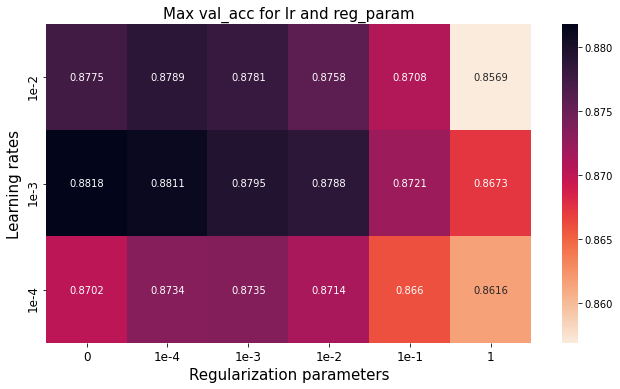

In [ ]:
plt.figure(figsize=(9, 5))
sns.heatmap(max_accuracies, annot = True, fmt = '.4g', cmap = 'rocket_r', # highest value gets darkest color
            xticklabels = reg_names, yticklabels = lr_names)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.tight_layout()
plt.title('Max val_acc for lr and reg_param', fontsize = 15)
plt.ylabel('Learning rates', fontsize = 15)
plt.xlabel('Regularization parameters', fontsize = 15)
plt.show()

In [ ]:
# Interesting results at lr = 1e-3 combined with reg_param = {0, 1e-4}
best_paths = hist_paths[1, :2]
best_histories = []

In [ ]:
# Get history objects from Drive
for path in best_paths:
  with open(path, 'rb') as f:
    best_histories.append(pickle.load(f))

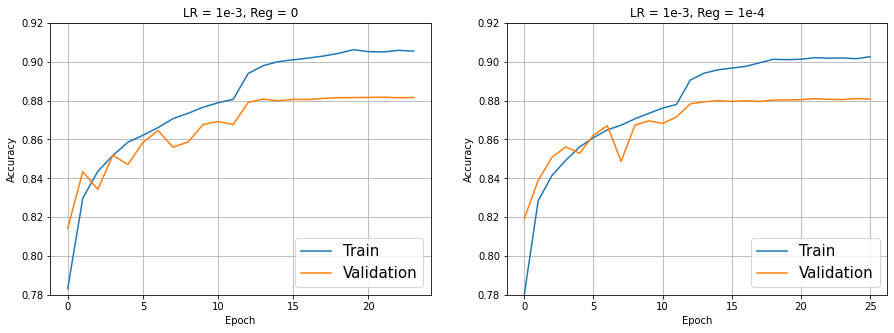

In [ ]:
# Plot accuracy curves created by the hyperparameter tuning
plot_base_index = 120
plt.figure(figsize = (15, 5))
for i in range(len(best_histories)):

  plt.subplot(plot_base_index + i + 1)
  plot_accuracy(best_histories[i], 'LR = 1e-3, Reg = ' + reg_names[i], 
                figsize = None, show = False)
  plt.ylim(top = 0.92, bottom = 0.78)
plt.show()

The best combination seems to be $lr = 10^{-3}$ and $reg = \left\{ 0, 10^{-4} \right\}$. Loss and accuracy are slightly better in the first point, but the overfitting is smaller in the second. Let's try out further combinations near these points.

###Learning rate and regularization parameter 2

In [ ]:
lrates   = [5e-4, 1e-3, 5e-3] 
lr_names = ['5e-4', '1e-3', '5e-3']
reg_params = [0, 5e-5] 
reg_names  = ['0', '5e-5']
os.chdir(drive_path + histories_dir + 'lr_reg_2')

In [ ]:
# Grid search for all defined combinations of lr and reg_param
for i in range(len(lrates)): 
  for j in range(len(reg_params)):

    if i == 1 and j == 0: # Don't retrain model for parameters it has already been trained on
      continue

    print("\n*** TRAINING WITH LR = " + lr_names[i] + " AND REG = " + reg_names[j] + " ***")

    with strategy.scope(): 
      model = model_class(lr = lrates[i], lr_schedule_index = 0, reg_param = reg_params[j], 
                          logs_dir = logs_dir, save_model_path = weights_file, model_name = model_name)
    model.callbacks = model.callbacks[1:3] # Don't save weights and deactivate Tensor Board

    history = model.fit(train_set,
                        epochs = epochs,
                        validation_data = cv_set,
                        callbacks = model.callbacks)
    
    # Save the history on Drive
    with open('History_' + model_name + '_lr_' + lr_names[i] + '_reg_' + reg_names[j] + '.pickle', 'wb') as f:
      pickle.dump(history.history, f)


*** TRAINING WITH LR = 5e-4 AND REG = 0 ***
Epoch 1/30
2621/2621 [==============================] - 32s 12ms/step - accuracy: 0.7739 - loss: 0.6259 - val_accuracy: 0.8262 - val_loss: 0.4829 - lr: 5.0000e-04
Epoch 2/30
2621/2621 [==============================] - 31s 12ms/step - accuracy: 0.8273 - loss: 0.4750 - val_accuracy: 0.8471 - val_loss: 0.4232 - lr: 5.0000e-04
Epoch 3/30
2621/2621 [==============================] - 31s 12ms/step - accuracy: 0.8405 - loss: 0.4383 - val_accuracy: 0.8530 - val_loss: 0.4066 - lr: 5.0000e-04
Epoch 4/30
2621/2621 [==============================] - 31s 12ms/step - accuracy: 0.8492 - loss: 0.4161 - val_accuracy: 0.8587 - val_loss: 0.3890 - lr: 5.0000e-04
Epoch 5/30
2621/2621 [==============================] - 31s 12ms/step - accuracy: 0.8551 - loss: 0.3987 - val_accuracy: 0.8632 - val_loss: 0.3781 - lr: 5.0000e-04
Epoch 6/30
2621/2621 [==============================] - 32s 12ms/step - accuracy: 0.8598 - loss: 0.3859 - val_accuracy: 0.8610 - val_loss: 0

In [ ]:
# Load histories from Drive (don't forget to copy the history for lr=1e-3 and reg=0 in this folder, too)
hist_paths = glob.glob('*.pickle')
list.sort(hist_paths)

In [ ]:
hist_paths = np.reshape(hist_paths, (len(lrates), len(reg_params))) # rows = lrates, cols = reg_params
# Swap first two rows to order lrates
temp = np.copy(hist_paths[0])
hist_paths[0] = hist_paths[1]
hist_paths[1] = temp
print(hist_paths)

[['History_Mosquito_CNN_PSD_lr_5e-3_reg_0.pickle'
  'History_Mosquito_CNN_PSD_lr_5e-3_reg_5e-5.pickle']
 ['History_Mosquito_CNN_PSD_lr_1e-3_reg_0.pickle'
  'History_Mosquito_CNN_PSD_lr_1e-3_reg_5e-5.pickle']
 ['History_Mosquito_CNN_PSD_lr_5e-4_reg_0.pickle'
  'History_Mosquito_CNN_PSD_lr_5e-4_reg_5e-5.pickle']]


In [ ]:
# Arrays to store min losses and max accuracies
min_losses = np.zeros(np.shape(hist_paths))
max_accuracies = np.zeros(np.shape(hist_paths))

In [ ]:
# Read history files and compute min_loss and max_acc
for i in range(np.shape(hist_paths)[0]):
  for j in range(np.shape(hist_paths)[1]):
    with open(hist_paths[i, j], 'rb') as f:
      complete_hist = pickle.load(f)
    min_losses[i, j] = min(complete_hist['val_loss'])
    max_accuracies[i, j] = max(complete_hist['val_accuracy'])

In [ ]:
print(min_losses)

[[0.33890721 0.34214598]
 [0.33583125 0.34215149]
 [0.34042954 0.34377268]]


In [ ]:
print(max_accuracies)

[[0.88063812 0.8814429 ]
 [0.88178271 0.8803162 ]
 [0.87924314 0.87985122]]


In [ ]:
lr_names = lr_names[::-1] # reverse lr labels, to have the highest value up on the map axis
print(lr_names)

['5e-3', '1e-3', '5e-4']


Plot minimal validation losses as heat map

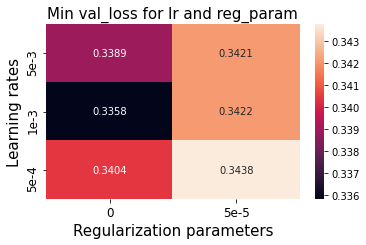

In [ ]:
plt.figure(figsize=(5, 3))
sns.heatmap(min_losses, annot = True, fmt = '.4g', cmap = 'rocket', # lowest value gets the darkest color
            xticklabels = reg_names, yticklabels = lr_names)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.tight_layout()
plt.title('Min val_loss for lr and reg_param', fontsize = 15)
plt.ylabel('Learning rates', fontsize = 15)
plt.xlabel('Regularization parameters', fontsize = 15)
plt.show()

Plot maximal validation accuracies as heat map

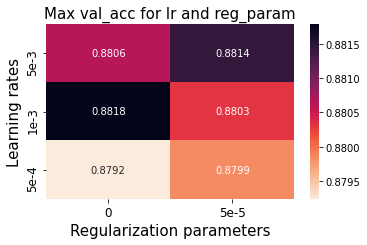

In [ ]:
plt.figure(figsize=(5, 3))
sns.heatmap(max_accuracies, annot = True, fmt = '.4g', cmap = 'rocket_r', # highest value gets darkest color
            xticklabels = reg_names, yticklabels = lr_names)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.tight_layout()
plt.title('Max val_acc for lr and reg_param', fontsize = 15)
plt.ylabel('Learning rates', fontsize = 15)
plt.xlabel('Regularization parameters', fontsize = 15)
plt.show()

A new interesting point comes forward: $lr = 5 \cdot 10^{-3}$ and $reg = 5 \cdot 10^{-5}$. Although its loss score is not strikingly impressive compared to its immediate neighbors, it does reach the second best accuracy score overall. It is at least worth plotting its accuracy curves to compare them to the previous best ones.

In [ ]:
# Read that specific history from Drive
with open('History_Mosquito_CNN_PSD_lr_5e-3_reg_5e-5.pickle', 'rb') as f:
  best_histories.append(pickle.load(f))

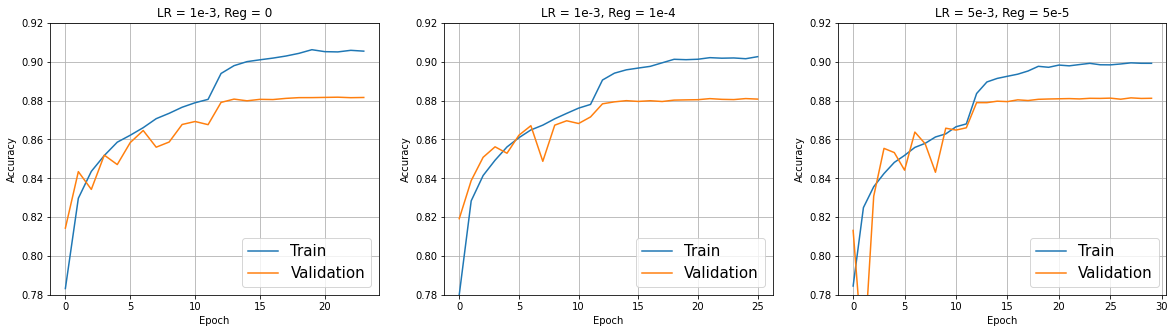

In [ ]:
# Plot accuracy curves created by the hyperparameter tuning
plot_base_index = 130
best_reg_names  = ['0', '1e-4', '5e-5']
best_lr_names   = ['1e-3', '1e-3', '5e-3']
plt.figure(figsize = (20, 5))
for i in range(len(best_histories)):

  plt.subplot(plot_base_index + i + 1)
  plot_accuracy(best_histories[i], 'LR = ' + best_lr_names[i] + ', Reg = ' + best_reg_names[i], 
                figsize = None, show = False)
  plt.ylim(top = 0.92, bottom = 0.78)
plt.show()

Indeed, overfitting is mostly reduced in the third plot.

**Conclusion**: The final model will be trained with $lr = 5 \cdot 10^{-3}$ and $reg = 5 \cdot 10^{-5}$

## Build model

In [ ]:
# Construct model with above defined parameters
with strategy.scope(): 
  model = model_class(lr = lr, reg_param = reg_param, lr_schedule_index = lr_schedule_index, 
                      logs_dir = logs_dir, save_model_path = weights_file, model_name = model_name)

In [ ]:
# Load previously trained weights
model.load_weights(weights_file)

Convert model to TFLite

In [ ]:
# Construct converter
converter = tf.lite.TFLiteConverter.from_keras_model(model)

### Optional: model quantization
quantizations = [None, 'QuantDyn', 'QuantFloat16', 'QuantFullInt']
quant_index = 3

if quant_index == 0: # no quantization
  # Just define name of unquantized TFLite model
  tf_file = model_name + '.tflite'

else:

  # This step is needed in all quantization strategies
  converter.optimizations = [tf.lite.Optimize.DEFAULT] # dynamic quantization

  if quant_index == 2: # float16-quantization
    converter.target_spec.supported_types = [tf.float16] 

  elif quant_index == 3: # full integer quantization

    # You need to measure the dynamic range of activations and inputs 
    # by supplying sample input data to the converter
    def representative_data_gen():
      for sig_batch, label_batch in train_set.take(1):
        for sig in sig_batch:
          yield [sig[tf.newaxis, :]] # Inputs to TFLite models require one extra dim.
    converter.representative_dataset = representative_data_gen

  # Define name of quantized TFLite model
  tf_file = model_name + '_' + quantizations[quant_index] + '.tflite'

# Apply converter
tflite_model = converter.convert()

# Save the TFLite model
with tf.io.gfile.GFile(tf_file, 'wb') as f:
  f.write(tflite_model)

In [ ]:
# Deactivate certain callbacks (especially TensorBoard, if training on TPU)
model.callbacks = model.callbacks[1:3]
print(model.callbacks)

ListWrapper([<tensorflow.python.keras.callbacks.EarlyStopping object at 0x7f886904a8d0>, <tensorflow.python.keras.callbacks.ReduceLROnPlateau object at 0x7f88cbc7a470>])


In [ ]:
# Load Tensor Board as notebook extension (once per session)
%load_ext tensorboard

In [ ]:
# Clear any logs from previous runs (it deletes the logs files on the drive)
#!rm -rf {model.logs_dir}

In [ ]:
# Start Tensor Board before training to visualize progress live
%tensorboard --logdir {model.logs_dir}

In [ ]:
# Train the model
history = model.fit(train_set,
                    epochs = epochs,
                    validation_data = cv_set,
                    callbacks = model.callbacks)

Epoch 1/30
2620/2621 [============================>.] - ETA: 0s - loss: 0.6203 - accuracy: 0.7817
Epoch 00001: val_loss improved from inf to 0.56801, saving model to Models/Mosquito_CNN_PSD/Mosquito_CNN_PSD.h5
2621/2621 [==============================] - 83s 31ms/step - loss: 0.6202 - accuracy: 0.7818 - val_loss: 0.5680 - val_accuracy: 0.8070 - lr: 0.0050
Epoch 2/30
2621/2621 [==============================] - ETA: 0s - loss: 0.5086 - accuracy: 0.8228
Epoch 00002: val_loss improved from 0.56801 to 0.49507, saving model to Models/Mosquito_CNN_PSD/Mosquito_CNN_PSD.h5
2621/2621 [==============================] - 84s 32ms/step - loss: 0.5086 - accuracy: 0.8228 - val_loss: 0.4951 - val_accuracy: 0.8314 - lr: 0.0050
Epoch 3/30
2621/2621 [==============================] - ETA: 0s - loss: 0.4835 - accuracy: 0.8344
Epoch 00003: val_loss did not improve from 0.49507
2621/2621 [==============================] - 80s 30ms/step - loss: 0.4835 - accuracy: 0.8344 - val_loss: 0.5559 - val_accuracy: 0.8

In [ ]:
# Print model architecture
model.summary()

Model: "Mosquito_CNN_PSD"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_norm_0 (BatchNormaliza (None, 129, 1)            4         
_________________________________________________________________
conv1d_16 (Conv1D)           (None, 129, 16)           64        
_________________________________________________________________
batch_norm_16 (BatchNormaliz (None, 129, 16)           64        
_________________________________________________________________
relu_16 (Activation)         (None, 129, 16)           0         
_________________________________________________________________
maxpool1d_16 (MaxPooling1D)  (None, 64, 16)            0         
_________________________________________________________________
conv1d_32 (Conv1D)           (None, 64, 32)            1568      
_________________________________________________________________
batch_norm_32 (BatchNormaliz (None, 64, 32)       

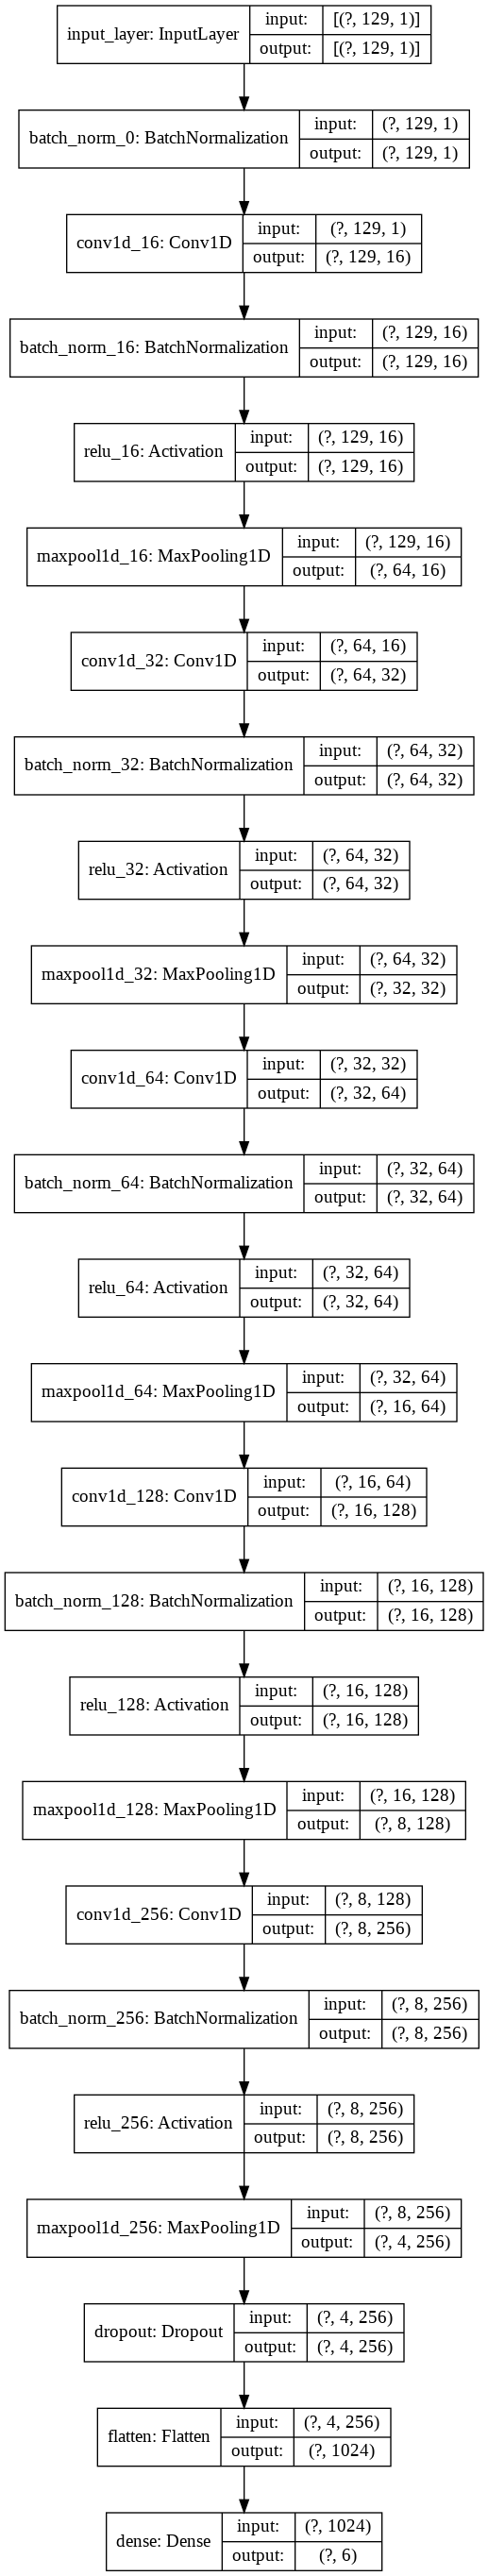

In [ ]:
# Save model graph
graph_file = drive_path + 'Models/' + model_name + '/' + model_name + '.png'
tf.keras.utils.plot_model(model, to_file = graph_file, show_shapes = True, show_layer_names = True)

# Predictions

In [ ]:
# Make predictions on validation set
y_pred = np.argmax(model.predict(X_cv, verbose = 1), axis = -1)
print(y_pred.shape)

1748/1748 [==============================] - 8s 5ms/step
(55914,)


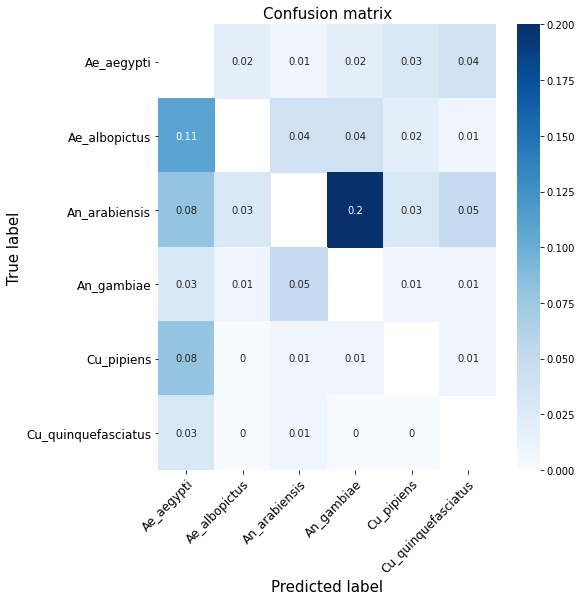

In [ ]:
# Build confusion matrix
plot_confusion(y_cv, y_pred, species, hide_diag = True)

Notice that most misclassifications occur within the *Anopheles* family (*Arabiensis* mistaken for *Gambiae* 20% of the time) and the *Aedes* family (*Albopictus* mistaken for *Aegypti* 11% of the time). It might be interesting to look at the 'within_family' variation of PSD values.

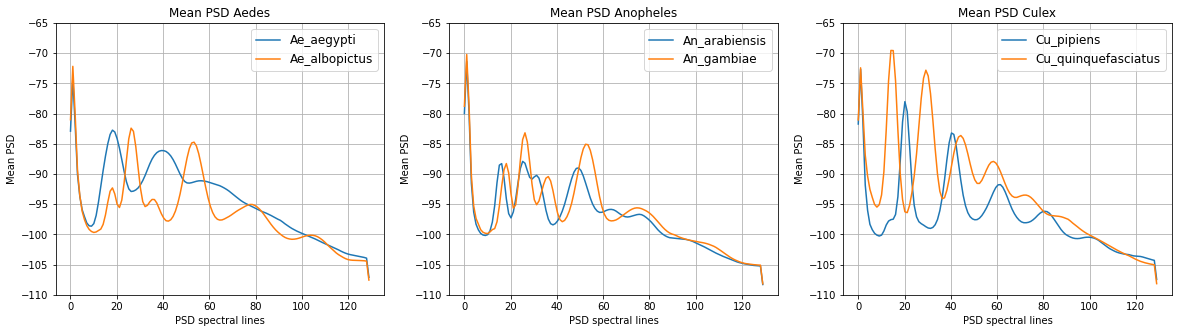

In [ ]:
# Plot mean PSD values per species and plot families together

ind_train = [0, 51331, 63469, 75046, 104728, 122977, 167736] 
fam_names = ['Aedes', 'Anopheles', 'Culex']
psd_means = [] # array for mean PSD values per species
plot_base_index = 130
plt.figure(figsize = (20, 5))
for i in range(0, len(species), 2):
  plt.subplot(plot_base_index + i//2 + 1)
  psd_means.append(mean_plot(X_train[ind_train[i]   : ind_train[i+1]], title = None, figsize = None))
  psd_means.append(mean_plot(X_train[ind_train[i+1] : ind_train[i+2]], title = None, figsize = None))
  plt.title('Mean PSD ' + fam_names[i//2])
  plt.xlabel('PSD spectral lines')
  plt.ylabel('Mean PSD')
  plt.legend([species[i], species[i+1]], fontsize = 12)
  plt.ylim(top = -65, bottom = -110)
  plt.grid()
plt.show()

In [ ]:
# Compute Root Mean Squared Deviation within each family
sqrt_num_values = np.sqrt(np.shape(psd_means)[1])
for i in range(len(fam_names)):
  rmsd = np.linalg.norm(psd_means[2*i] - psd_means[2*i+1]) / sqrt_num_values
  print('RMSD ' + fam_names[i] + ': ' + str(rmsd))

RMSD Aedes: 4.794457954690514
RMSD Anopheles: 2.717138052001898
RMSD Culex: 8.403822352767095


The *Anopheles* family has, indeed, the least intrinsic variation, which gives an explanation for the classifier being confused when telling the two species apart.